# Fused Softmax
- 본 튜토리얼에서는 특정 행렬(행이 GPU의 SRAM에 맞는)에서 pytorch의 연산보다 더 빠른 fused softmax 연산을 수행한다.
- 이를 통해 bandwidth-bound 연산에 대한 kernel fusion의 이점을 학습하고 Triton의 Reduction 연산을 배운다

# 1. naive_softmax()

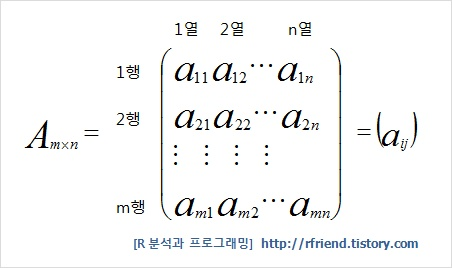

In [1]:
import torch
import triton
import triton.language as tl

@torch.jit.script
def naive_softmax(x):
    """native pytorch를 사용한 x의 행 방향 softmax 연산
    
    overflow를 방지하기 위해서 가장 큰 원소를 빼줍니다.
    이러한 연산을 해도 softmax 값에는 변화가 없습니다.
    """
    
    # read MN 원소 ; write M 원소
    # 행 방향으로 softmax를 수행 == 행 별로 최대 값을 구해야한다. 
    # 따라서 모든 M x N 개의 값을 불러와서 대소비교를 하고 행 별로 최대값을 써줘야한다.
    x_max = x.max(dim = 1)[0]

    # read MN + M 원소 ; write MN 원소
    # x의 모든 원소를 불러오고(read 연산 M x N 번), x_max의 모든 값을 불러온다 (행이 M개니까 read 연산 M 번)
    # x의 모든 원소에 대해서 빼기 연산을 진행하고 다시 써야하므로 write M x N 번
    z = x - x_max[:, None]

    # read MN 원소, write MN 원소
    # z의 모든 원소를 불러오고(read 연산 M x N 번), exp함수에 넣어주고(softmax 값을 구해야하니까)
    # 그 결과를 다시 numerator 변수에 write 해준다. (write 연산 M x N 번) 
    numerator = torch.exp(z)

    # read MN 원소 ; write M 원소
    # numerator에 저장된 모든 원소를 읽어와서(read 연산 M x N번 수행) 행마다 sum을 수행
    # 결과값을 denominator에 쓰는데 행 방향 결과값이므로 write M 번 수행
    denominator = numerator.sum(dim = 1)

    # read MN + M 원소 ; write MN 원소
    # numerator의 값들을 모두 읽어오고(read M x N), denominator의 값을 모두 읽어오면(read M 번)
    # 나누기 연산을 총 M x N 번 수행하고 결과를 저장한다.(write M x N 번 수행)
    ret = numerator / denominator[:, None]
    
    # 총 : read 5MN + 2M 원소 ; wrote 3MN + 2M 원소
    return ret

- pytorch로 나이브하게 구현하는 경우에 x가 M x N 행렬일때, 즉 $ x \in R^{M \times N} $ 일때 y = naive_softmax(x) 를 계산하면 DRAM에서 5MN + 2M 개의 원소들을 read하고 3MN + 2M 개의 원소를 다시 write 해야한다.
- 이는 매우 비효율적이다. 따라서, x를 한번만 읽고 gpu chip 상에서 모든 계산을 끝내고자 한다.
- 이렇게 수행하면 MN byte만 읽기 / 쓰기 연산을 하므로 효율적이고 이론상 4배 가량 속도가 빨라질 것이다. ((8MN + $M) / 2MN))
- @torch.jit.script 플래그는 이러한 "kernel fusion" 연산을 자동으로 적용하는게 목표지만 아직은 무리다.

## 상세 코드 분석
#### 1. `torch.max()`
`torch.max()` 메서드 동작 방식을 살펴보면 코드 이해에 도움이 된다.
- 아래 코드에서 `y.max(dim=0)`을 수행하는 경우 열 방향으로 최대 값을 찾는다.
    그리고 그 결과는 values와 indices로 값, 인덱스로 구성되어있다.
    따라서 우리에게 필요한 값만 추출하려면 인덱스를 지정해서 추출해야한다.
- 아래 코드에서 `y.max(dim=1)`을 수행하는 경우 행 방향으로 최대 값을 찾는다.
    그리고 그 결과는 values와 indices로 값, 인덱스로 구성되어있다.
    따라서 우리에게 필요한 값만 추출하려면 인덱스를 지정해서 추출해야한다.
- 따라서, `y.max(dim=1)[0]`의 결과는 `tensor([3., 6., 9.])` 이다.


In [ ]:
y = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0],
                  [7.0, 8.0, 9.0]])

print("y.max : ", y.max , "\n")
print("y.max(dim=0) : ", y.max(dim=0) , "\n")
print("y.max(dim=1) : ", y.max(dim=1) , "\n")
print("y.max(dim=1)[0] : ", y.max(dim=1)[0] , "\n")

y_max = y.max(dim = 1)[0]

#### 2. `t = y - y_max[:,None]`
- 아래 코드 실행 결과를 살펴보면 알 수 있는 것처럼 y는 2차원 배열이고 
    y_max는 1차원 배열이다. 따라서 `y_max[:,None]`을 통해서 2차원 배열로
    차원을 맞춰준다.

#### 3. `torch.exp()`
- 이후 torch.exp() 함수에 z를 넣어서 원소  별로 값을 구한다.

In [ ]:
t = y - y_max[:,None]
print("="*30,"\n" ,"y : ",y,"\n")
print("="*30,"\n" ,"y_max[:] : ",y_max[:],"\n")
print("="*30,"\n" ,"y_max[:,None] : ",y_max[:,None],"\n")
print("="*30,"\n" ,"z : ",t,"\n")

numerator = torch.exp(t)
print("="*30,"\n" ,"numerator : ",numerator,"\n")

#### 4. `torch.sum()`
- `numerator.sum(dim=0)`의 경우 열 방향(아래로)으로 값을 모두 더한다.
- `numerator.sum(dim=1)`의 경우 행 방향(오른쪽)으로 값을 모두 더한다.

In [ ]:
denominator = numerator.sum(dim = 1)
print("="*20,"\n" ,"numerator.sum(dim = 0) : ",numerator.sum(dim = 0),"\n")
print("="*20,"\n" ,"numerator.sum(dim = 1) : ",numerator.sum(dim = 1),"\n")

#### 5. `denominator[:, None]`
- 여기서도 앞선 z를 구할 때처럼 차원을 맞춰주기 위해서 `denominator[:, None]`를
    사용해서 결과값을 구한다.

In [ ]:
ret = numerator / denominator[:, None]
print("="*20,"\n" ,"denominator[:] : ",denominator[:],"\n")
print("="*20,"\n" ,"denominator[:, None] : ",denominator[:, None],"\n")
print("="*20,"\n" , "ret : ", ret)

# Compute Kernel
# 2. softmax_kernel
- Triton의 softmax kernel은 다음과 같이 동작합니다.
각 프로그램은 input 행렬 X의 행을 load 하고, 정규화하고 결과를 출력값 Y에 write back 합니다.

- 한가지 중요한 Triton의 제한 사항은 각 블록이 원소의 2의 거듭제곱 수를 가져야한다.
따라서, Triton을 사용하는 개발자가 input shape을 처리하려면 내부적으로 각 행에 pad를 넣고 메모리 작업을 적절하게 보호해야합니다.

In [2]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
    
    # softmax의 각 행은 독립적이라, 병렬화가 가능
    # 현재 program의 1차원 블록 id 반환
    row_idx = tl.program_id(0)
    #print("row_idx :",row_idx)
    
    # Stride는 1행을 넘어가기 위해서 포인터가 얼마나 이동해야하는지 알려준다.
    # 행의 크기라고 생각하면 된다.
    # input_ptr의 위치에서 계산을 위한 (몇 번째 program인지 x stride(행 크기))
    row_start_ptr = input_ptr + row_idx * input_row_stride

    # BLOCK SIZE는 n_cols보다 큰 2의 거듭제곱이라 각 행을 하나의 block에 맞출 수 있다.
    # input_ptrs 에는 행 시작 포인터에 offset을 더해줘서 만든 각 원소의 위치를 가리키는 
    # pointer의 리스트
    col_offsets = tl.arange(0,BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets

    # 행을 SRAM에 load하고 BLOCK_SIZE가 n_cols보다 클 수 있으므로 mask를 사용한다
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other = -float('inf')) 
    
    # 수치적인 안정성을 위해서 최대값을 빼준다
    row_minus_max = row - tl.max(row, axis = 0)

    # Triton의 exp 함수는 빠르지만 근사치이다.(CUDA의 __expf 포지션)
    # 정규화한 row를 exp 함수에 넣어서 numerator에 저장한다.
    numerator = tl.exp(row_minus_max)

    # numerator에 저장된 값을 행마다 합을 구해주고 그 값으로 numerator를 원소별로
    # 나눠서 softmax 값을 구한다.
    denominator = tl.sum(numerator, axis = 0)
    softmax_output = numerator / denominator

    # 최종 결과값을 DRAM에 Write back
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)

In [3]:
def softmax(x):
    
    # x의 행 개수, 열 개수를 저장
    n_rows, n_cols = x.shape

    # Block size는 x의 열의 개수보다 큰 2의 최소 거듭제곱
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # num_warps : 각 행당 사용할 쓰레드 수이다. BLOCK_SIZE가 클수록 많은 warp를 사용한다.
    # warps의 개수를 늘려서 컴파일러에게 row 당 더 많은 thread를 사용하게 요청할 수 있다.
    # 다음 튜토리얼에서 이 값을 직접 찾지 않고 auto-tune 하는 방법을 실습한다.
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16
    
    # output 할당
    y = torch.empty_like(x)

    # 커널을 enqueue한다. 1D launch grid는 간단하다 : 행별로 하나의 kernel 인스턴스를 가진다.
    softmax_kernel[(n_rows, )](y,x,x.stride(0),y.stride(0),n_cols,num_warps=num_warps, BLOCK_SIZE=BLOCK_SIZE)
    return y

#### `torch.empty_like()`
- 이 함수는 주어진 텐서와 동일한 크기와 데이터 타입을 가지지만, 초기화되지 않은 텐서를 생성

- 초기화되지 않았다는 의미는 생성된 텐서의 값이 메모리에 이미 존재하는 임의의 값으로 채워져 있을 수 있다는 것

- torch.empty_like() 함수는 텐서의 값이 필요 없는 경우, 예를 들어 나중에 값을 덮어쓸 예정인 경우에 사용하면 효율적

# Unit Test
방금 정의한 kernel을 행과 열의 수가 불규칙한 행렬에 테스트한다. 

이를 통해 우리의 padding 메커니즘이 작동하는지 확인한다

In [4]:
torch.manual_seed(0)
x=  torch.rand(1823, 781, device = "cuda")
y_triton = softmax(x)
y_torch = torch.softmax(x, axis = 1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

- `torch.manual_seed(0)`
    - 난수 생성기의 시드를 설정 => for 재현성
- `x = torch.rand(1823, 781, device="cuda")`
    - 1823 x 781 크기 tensor 생성
    - 각 원소 0~1 난수로 초기화
    - GPU 메모리에 tensor 할당

- `assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)`
    - y_triton과 y_torch의 모든 원소가 거의 동일한지 확인(허용 오차 내인지)
    - assert 문을 사용하여 이 조건이 참인지 확인
        - 조건이 거짓이면, AssertionError가 발생, (y_triton, y_torch)를 출력

# Benchmark
4096개의 행을 가진 행렬로 실험을 한다. torch_softmax와 naive_softmax의 성능을 triton으로 정의한 fusion_softmax와 비교한다.

In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N',], # x축에 사용할 이름
        x_vals=[128 * i for i in range(2,100)], # x_name 값
        line_arg = 'provider',  # 서로 다른 선 이름에 해당하는 매개변수명
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ], # line_arg에 매칭할 변수명
        line_names = [
            'Triton',
            'Torch (native)',
            'Torch (jit)',
        ], # 선들의 레이블명(그림에 표시되는 선)
        styles=[('blue','-'),('green','-'),('green','--')], # 선 스타일
        ylabel = "GB/s", # y축 레이블명
        plot_name = "softmax-performance", # plot 이름. 이미지 저장시 파일명
        args={'M':4096}, # benchmark에 들어갈 함수 매개변수
    ))

def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype = torch.float32)
    quantiles = [0.5,0.2,0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis = -1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)

    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    
    return gbps(ms), gbps(max_ms), gbps(min_ms)

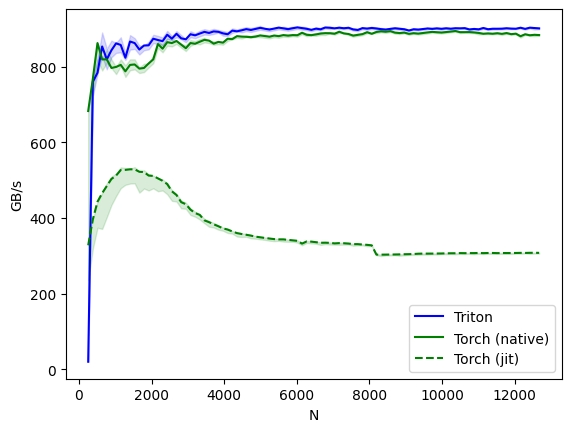

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0   19.835351      682.666643   327.680008
1     384.0  759.837707      768.000002   396.387102
2     512.0  783.689121      862.315828   442.810792
3     640.0  853.333303      819.200021   465.454542
4     768.0  819.200021      819.200021   484.256150
..      ...         ...             ...          ...
93  12160.0  902.830641      880.362012   307.604750
94  12288.0  899.807760      885.621612   307.455225
95  12416.0  902.981811      882.915571   307.755216
96  12544.0  902.040424      884.158603   307.828213
97  12672.0  901.120015      883.450975   307.658872

[98 rows x 4 columns]


In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # x축에 사용할 이름
        x_vals=[128 * i for i in range(2, 100)],  # x_name 값
        line_arg='provider',  # 서로 다른 선 이름에 해당하는 매개변수명
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # line_arg에 매칭할 변수명
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # 선들의 레이블명(그림에 표시되는 선)
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # 선 스타일
        ylabel="GB/s",  # y축 레이블명
        plot_name="softmax-performance",  # plot 이름. 이미지 저장시 파일명
        args={'M': 4096},  # benchmark에 들어갈 함수 매개변수
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)

### 결과 확인
1. Triton을 사용한게 torch native보다 성능이 좋은 것을 확인할 수 있다.
2. 아직은 triton에서 자동으로 최적화 해주는 함수는 느리다.
3. Triton은 행렬의 크기가 클때 더 효과적이다. 반대로 말하면 행렬의 크기가 작으면 성능이 안좋다

# 최종 코드

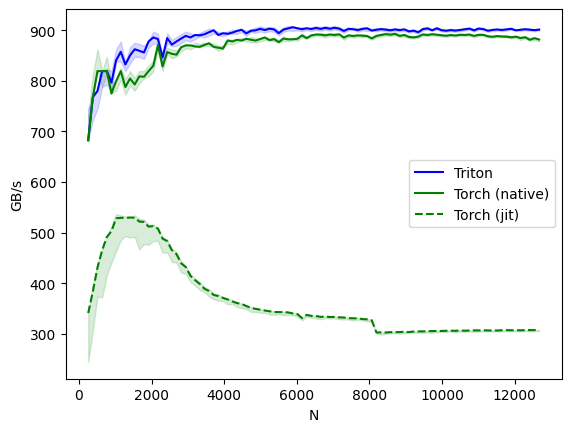

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  682.666643      682.666643   341.333321
1     384.0  768.000002      768.000002   384.000001
2     512.0  780.190482      819.200021   431.157914
3     640.0  819.200021      819.200021   465.454542
4     768.0  819.200021      819.200021   491.520012
..      ...         ...             ...          ...
93  12160.0  900.740739      884.363629   307.361775
94  12288.0  901.871555      885.995739   307.680763
95  12416.0  900.934218      880.957872   307.755216
96  12544.0  900.017956      884.158603   307.724999
97  12672.0  901.120015      881.530415   307.666155

[98 rows x 4 columns]


In [7]:
import torch

import triton
import triton.language as tl


@torch.jit.script
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
    # The rows of the softmax are independent, so we parallelize across those
    row_idx = tl.program_id(0)
    # The stride represents how much we need to increase the pointer to advance 1 row
    row_start_ptr = input_ptr + row_idx * input_row_stride
    # The block size is the next power of two greater than n_cols, so we can fit each
    # row in a single block
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))
    # Subtract maximum for numerical stability
    row_minus_max = row - tl.max(row, axis=0)
    # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator
    # Write back output to DRAM
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)

def softmax(x):
    n_rows, n_cols = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The 1D launch grid is simple: we have one kernel instance per row o
    # f the input matrix
    softmax_kernel[(n_rows, )](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return y

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)